In [30]:
import numpy as np

import chugunov_indicator as chug
from chugunov_indicator.plotting import plt

In [31]:
data = chug.DetonationData("./data/subch_plt08582/")

yt : [INFO     ] 2024-09-12 05:11:20,660 Parameters: current_time              = 0.40003216130915
yt : [INFO     ] 2024-09-12 05:11:20,661 Parameters: domain_dimensions         = [ 640 1280    1]
yt : [INFO     ] 2024-09-12 05:11:20,662 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-09-12 05:11:20,662 Parameters: domain_right_edge         = [5.12000000e+09 1.02400000e+10 6.28318531e+00]


In [32]:
T, D = data.D_T_meshgrid()

In [33]:
i = 1000
kwargs = {
    "abar": data.data["abar"][i],
    "zbar": data.data["zbar"][i],
    "z2bar": data.data["z2bar"][i],
    **data.data["ScreenFactors"][1]
}
kwargs

{'abar': 4.028776983649795,
 'zbar': 2.0143884920095214,
 'z2bar': 4.12949645671095,
 'z1': 2,
 'a1': 4,
 'z2': 6,
 'a2': 12}

In [34]:
screening_factors = chug.chugunov_2009(temp=T, dens=D, **kwargs)
screening_factors

array([[1.00075906e+00, 1.00069966e+00, 1.00064489e+00, ...,
        1.00000026e+00, 1.00000024e+00, 1.00000022e+00],
       [1.00087139e+00, 1.00080327e+00, 1.00074045e+00, ...,
        1.00000030e+00, 1.00000028e+00, 1.00000026e+00],
       [1.00100019e+00, 1.00092210e+00, 1.00085005e+00, ...,
        1.00000035e+00, 1.00000032e+00, 1.00000029e+00],
       ...,
       [1.69904959e+22, 1.79338609e+21, 2.04417093e+20, ...,
        1.14598812e+00, 1.13517326e+00, 1.12521157e+00],
       [5.43677396e+23, 5.26228163e+22, 5.48934298e+21, ...,
        1.16651755e+00, 1.15405224e+00, 1.14259400e+00],
       [1.80977922e+25, 1.62278991e+24, 1.56412667e+23, ...,
        1.19025164e+00, 1.17582881e+00, 1.16260190e+00]])

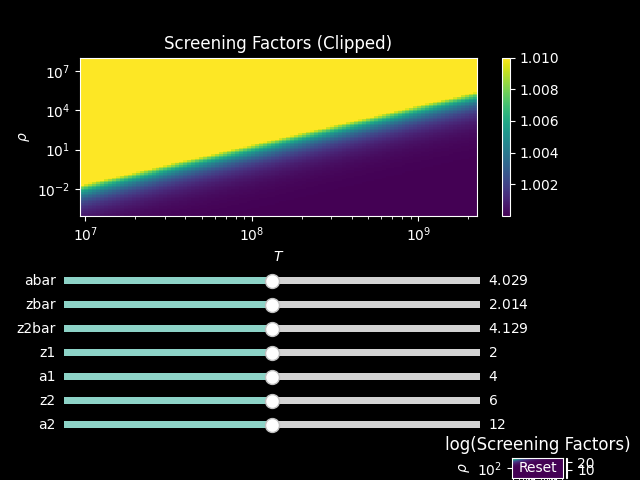

In [35]:
chug.D_T_colorgraph(T, D, np.log10(screening_factors))

plt.title("log(Screening Factors)")
plt.show()

As shown above, the screening factor increases with $\rho$ and decreases with $T$.

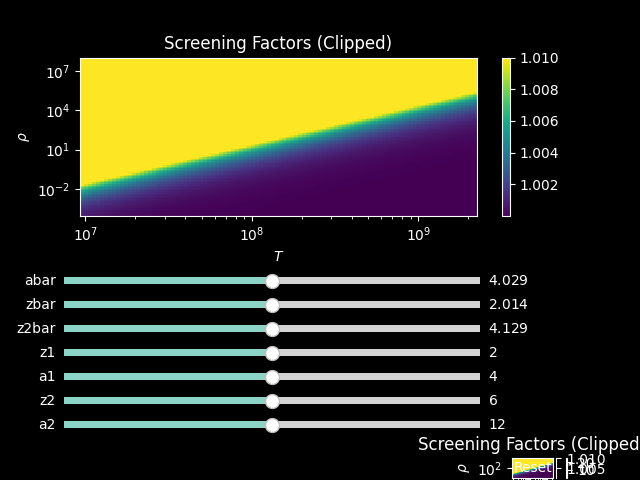

In [36]:
chug.D_T_colorgraph(T, D, np.where(screening_factors > data.threshold, data.threshold, screening_factors))

plt.title("Screening Factors (Clipped)")
plt.show()

Computing the screening can be skipped when the density and temperature lie below the line separating the yellow and green regions. We can model this as
$$
    \rho(T) \leq 10^{-c} T^{k},
$$
where in log-log space, $-c$ is the $\log \rho$-intercept and $k$ is the slope of the line. The parameters $k,c$ are functions of the parameters
$$
    \braket{A}, \braket{Z}, \braket{Z^2}; Z_1, A_1, Z_2, A_2,
$$
where the first three are properties of the composition/plasma state, and the latter four are properties of the screening pair in question.

In [37]:
def clip(x: np.ndarray, maximum: float = 1.01) -> np.ndarray:
    return np.where(x > 1.01, 1.01, x)

In [38]:
from matplotlib.widgets import Slider, Button

C:\Users\Sam\AppData\Local\Temp\ipykernel_14180\2939247722.py:26: MatplotlibDeprecationWarning: Passing the valinit parameter of __init__() positionally is deprecated since Matplotlib 3.7; the parameter will become keyword-only two minor releases later.
  sliders[key] = Slider(ax_sliders[key], key, 0, 200, kwargs[key])


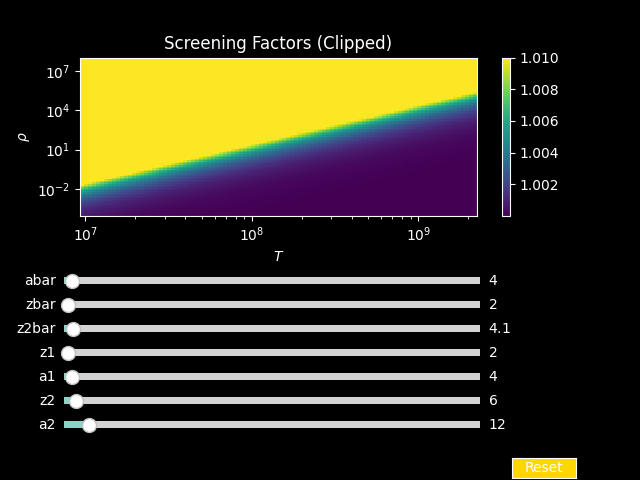

c:\Users\Sam\Documents\Code\microphysics\screening_indicator\chugunov_indicator\chugunov_2009.py:13: RuntimeWarning: divide by zero encountered in divide
  ntot = dens / mbar
c:\Users\Sam\Documents\Code\microphysics\screening_indicator\chugunov_indicator\chugunov_2009.py:90: RuntimeWarning: invalid value encountered in divide
  term1 = f0(Gamma_1 / t_12)
c:\Users\Sam\Documents\Code\microphysics\screening_indicator\chugunov_indicator\chugunov_2009.py:91: RuntimeWarning: invalid value encountered in divide
  term2 = f0(Gamma_2 / t_12)
c:\Users\Sam\Documents\Code\microphysics\screening_indicator\chugunov_indicator\chugunov_2009.py:92: RuntimeWarning: invalid value encountered in divide
  term3 = f0(Gamma_comp / t_12)
c:\Users\Sam\Documents\Code\microphysics\screening_indicator\chugunov_indicator\chugunov_2009.py:105: RuntimeWarning: invalid value encountered in divide
  h12 = numer / denom * h_fit


In [43]:
%matplotlib widget

# Screening Factor Graph
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.55)

cb, cbar = chug.D_T_colorgraph(T, D, clip(screening_factors))
plt.title("Screening Factors (Clipped)")

# Slider dictionaries
ax_sliders = {}
sliders = {}

# Create function to be called when slider value is changed
def update(val) -> None:
    kwargs_new = {key: sliders[key].val for key in kwargs}
    y_new = clip(chug.chugunov_2009(T, D, **kwargs_new))

    cb.set_array(y_new)
    #cbar = plt.colorbar(cb)

for j, key in enumerate(kwargs):
    # Create axes
    ax_sliders[key] = plt.axes([0.1, 0.4 - j*0.05, 0.65, 0.03])
    # Create sliders
    sliders[key] = Slider(ax_sliders[key], key, 0, 200, kwargs[key])
    # Call update function when slider value is changed
    sliders[key].on_changed(update)

# Create axes for reset button and create button
resetax = plt.axes([0.8, 0.005, 0.1, 0.04])
button = Button(resetax, 'Reset', color='gold',
                hovercolor='skyblue')
 
# Create a function resetSlider to set slider to
# initial values when Reset button is clicked
 
def resetSlider(event) -> None:
    for slider in sliders.values():
        slider.reset()
 
# Call resetSlider function when clicked on reset button
button.on_clicked(resetSlider)

# Show graph
plt.show()

Based on the above, it would seem that changes in $A_1, A_2$ have no impact on the location of this line.

From there, the line's height significantly increases with $\braket{A}$, significantly decreases with $\braket{Z^2}, Z_1, Z_2$, and weakly decreases with $\braket{Z}$. Note that decreases in the line's height correspond to screening being more important.

Physically, this makes sense - stronger charges $\braket{Z^2}, Z_1, Z_2$ will cause more screening, while a composition with increased mass $\braket{A}$ will resist that screening more easily.

Curiously, none of these parameters seem to impact the *slope* of the line to any visible degree - while proper data analysis will be required to confirm this, if the slope doesn't change, this suggests that the power law $\rho \propto T^k$ for this border may hold more generally than previously expected.